In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.optim.lr_scheduler as lr_scheduler

### Constants

In [ ]:
D = 1 # Number of dimensions
Nh = 100 # Hidden dimension 
num_layers = 2
num_samples = 50

l = 5
data_range = (-l, l)

### Laplacian calculation and different potentials

In [ ]:
def kinematics_f(x, psi):
    constant = -1/2
    grad_x_values = torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    laplacian_values = torch.zeros_like(x) 
    
    # Compute the Laplacian for each dimension separately
    for i in range(x.shape[1]):
        laplacian_dim = torch.autograd.grad(grad_x_values[:, i].sum(), x, create_graph=True)[0]    
        laplacian_values[:, i] = laplacian_dim[:, i]
    laplacian_values = torch.sum(laplacian_values, dim=1).view(-1,1)
    return constant * laplacian_values, grad_x_values

def HO_potential(x):
    potential = torch.square(x)/2
    potential_3d = torch.sum(potential, dim=1).view(-1,1)
    return potential_3d

def Nilsson_model(x):
    x_freq = 4
    y_freq = 2
    z_freq = 2
    if x.shape[1] == 2: 
        freq_reg = torch.tensor([x_freq, y_freq])
    elif x.shape[1] == 3: 
        freq_reg = torch.tensor([x_freq, y_freq, z_freq])
    potential = freq_reg * torch.square(x)/2
    potential_3d = torch.sum(potential, dim=1).view(-1,1)
    return potential_3d

def HA_potential(x):
    r = torch.sqrt(torch.sum(torch.square(x), dim=1))
    potential_3d = -1 / r
    return potential_3d.view(-1,1)

def Woods_potential(x):
    V_0 = 6.5
    a = 0.3
    R = 3
    r = torch.sqrt(torch.sum(torch.square(x), dim=1))
    potential_3d = -V_0 / (1 + torch.exp((r - R) / a))
    return potential_3d.view(-1,1)

### A loss function which takes into account the different elements of a wave function.
1. The main differential equation denoted as L_DE.
2. The normalization criterion for a wave function denoted as L_norm.
3. The orthogonality between different solutions denoted as L_orth.
4. The boundary conditions denoted as L_BC.

In [ ]:
def schrodinger_loss(x, psi, E, data_range, solutions, model_list, edge_indices):
    M = x.shape[0]
    x_R = data_range[1]
    x_L = data_range[0]
    L_norm = torch.square(torch.sum(torch.square(psi)) * ((x_R - x_L)**x.shape[1])/M - 1)

    psi_eigen = torch.zeros((M, 1))
    for i in range(solutions):
        psi_eigen += torch.square(torch.mean(psi * model_list[i](x)[0]))
    L_orth = torch.sum(psi_eigen)
    
    kinematics, grads = kinematics_f(x, psi)
    potential = HO_potential(x)
    H_psi = kinematics + potential * psi
    L_DE = torch.mean(torch.square(H_psi - E * psi))

    L_BC = torch.sum(torch.square(psi[edge_indices]) + torch.square(grads[edge_indices]))
    
    total_loss = L_DE + L_norm + L_orth + L_BC
    return total_loss, L_DE, L_orth, L_norm, L_BC, torch.sum(psi * H_psi) / torch.sum(psi * psi)

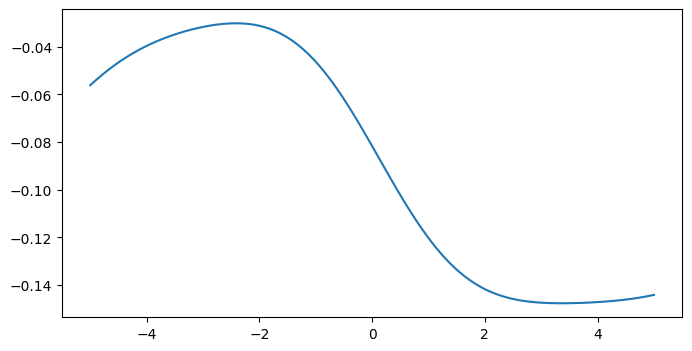

Epoch [1/10000], Loss: 1.438034176826477, L_orth: 0.0, Energy: 0.33910560607910156, LDE_Loss: 0.6421, Vari_E: 6.0266, Solutions: 0


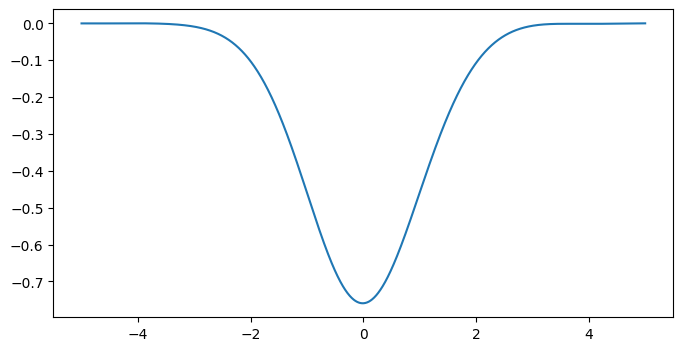

Epoch [501/10000], Loss: 0.00012174471339676529, L_orth: 0.0, Energy: 0.48091375827789307, LDE_Loss: 0.0001, Vari_E: 0.5001, Solutions: 0


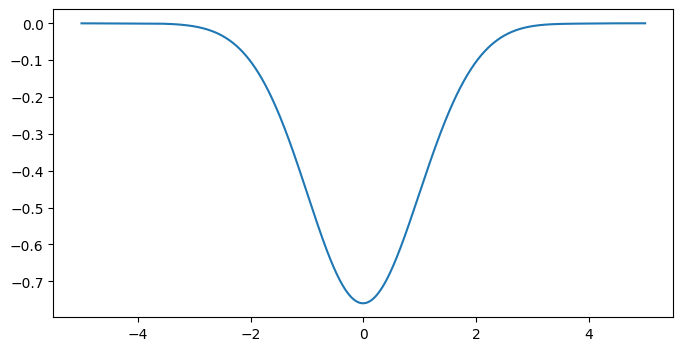

Epoch [1001/10000], Loss: 2.05607466341462e-05, L_orth: 0.0, Energy: 0.4993526339530945, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


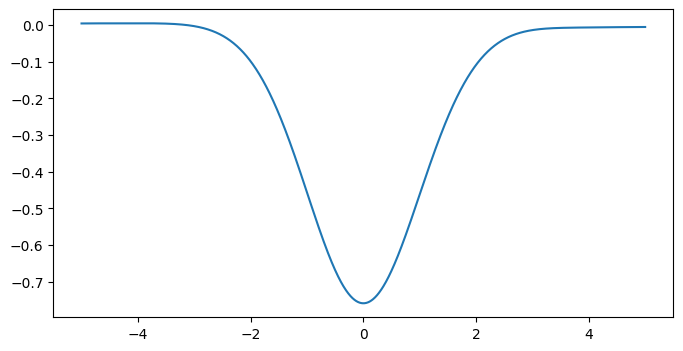

Epoch [1501/10000], Loss: 0.0005462999106384814, L_orth: 0.0, Energy: 0.5001121759414673, LDE_Loss: 0.0005, Vari_E: 0.5007, Solutions: 0


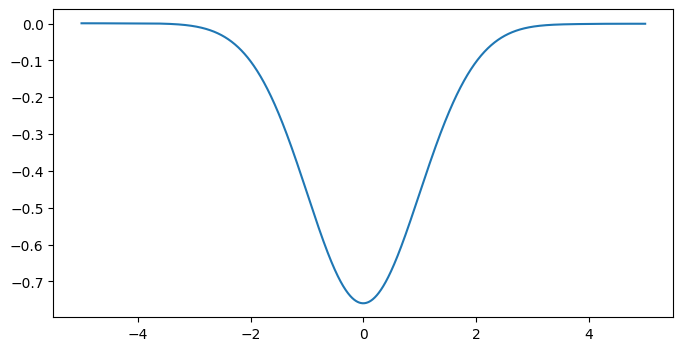

Epoch [2001/10000], Loss: 5.493422213476151e-05, L_orth: 0.0, Energy: 0.500842809677124, LDE_Loss: 0.0001, Vari_E: 0.5001, Solutions: 0


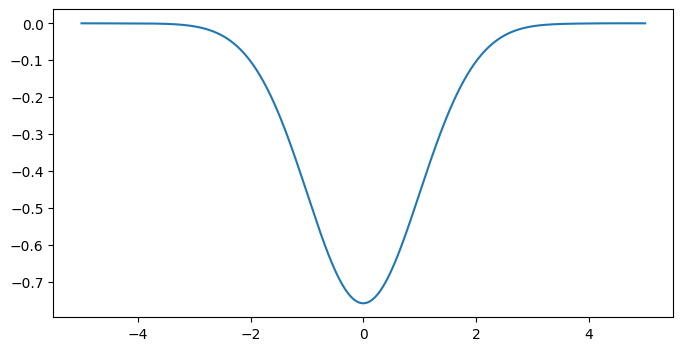

Epoch [2501/10000], Loss: 5.229789167060517e-06, L_orth: 0.0, Energy: 0.5000443458557129, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


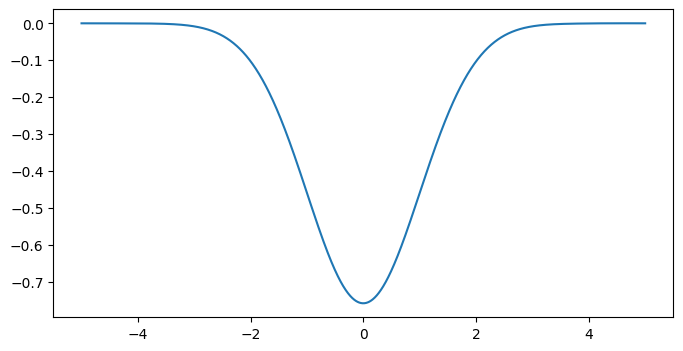

Epoch [3001/10000], Loss: 3.799434352913522e-06, L_orth: 0.0, Energy: 0.5000351071357727, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


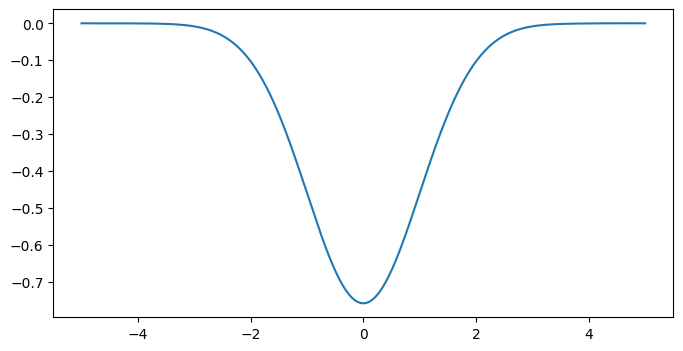

Epoch [3501/10000], Loss: 2.9407351576082874e-06, L_orth: 0.0, Energy: 0.5000309944152832, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


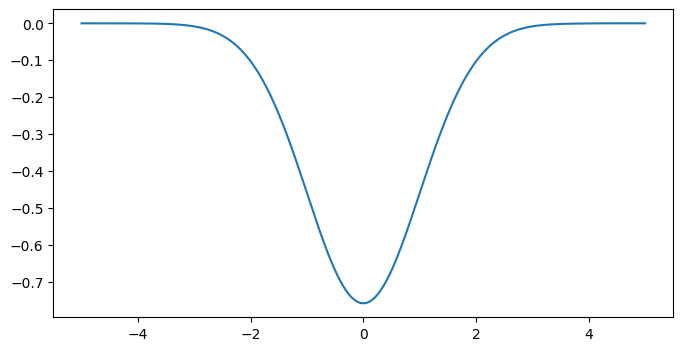

Epoch [4001/10000], Loss: 2.4221478724939516e-06, L_orth: 0.0, Energy: 0.5000402927398682, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


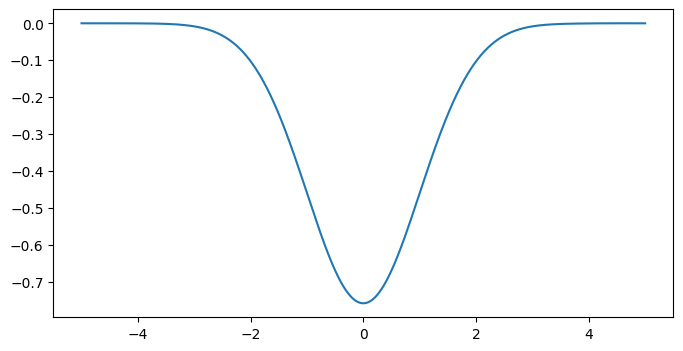

Epoch [4501/10000], Loss: 2.1373552954173647e-06, L_orth: 0.0, Energy: 0.500127911567688, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


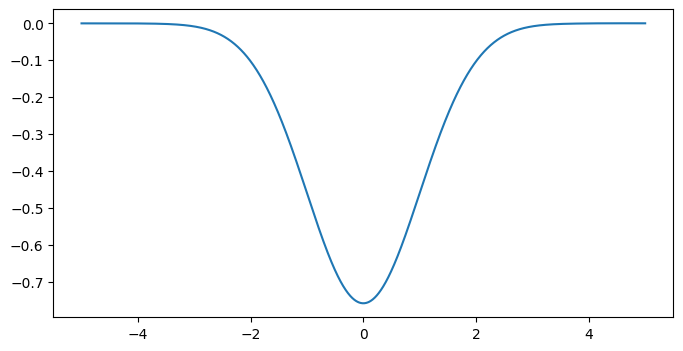

Epoch [5001/10000], Loss: 2.054835249509779e-06, L_orth: 0.0, Energy: 0.5000095367431641, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


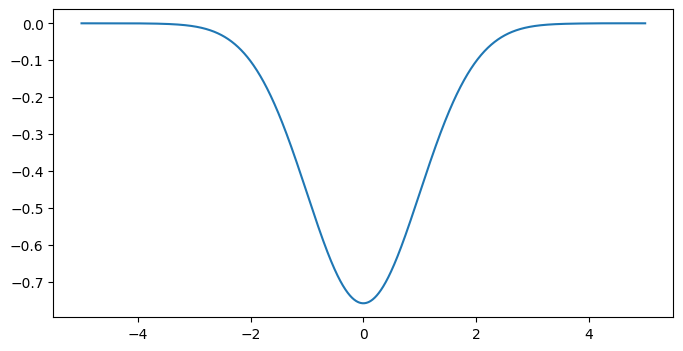

Epoch [5501/10000], Loss: 1.7848915376816876e-06, L_orth: 0.0, Energy: 0.5000066757202148, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


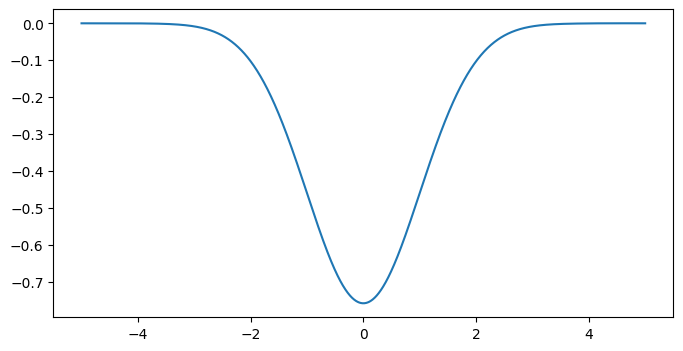

Epoch [6001/10000], Loss: 1.6959387494352995e-06, L_orth: 0.0, Energy: 0.5000047087669373, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


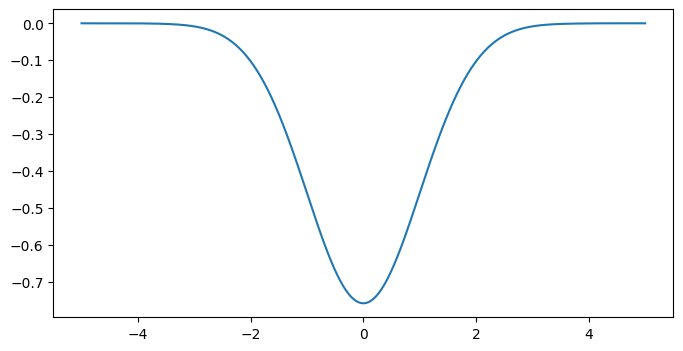

Epoch [6501/10000], Loss: 1.6298411082971143e-06, L_orth: 0.0, Energy: 0.5000032782554626, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


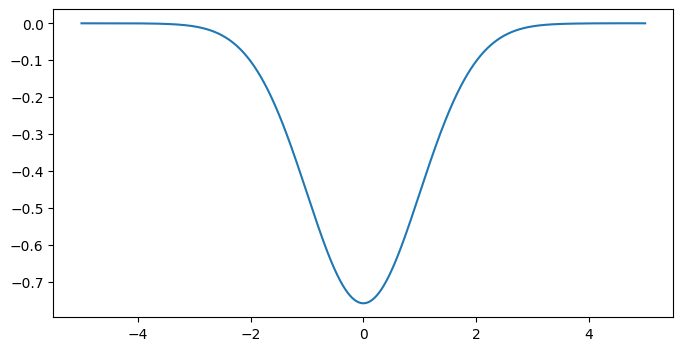

Epoch [7001/10000], Loss: 1.5760731457703514e-06, L_orth: 0.0, Energy: 0.5000022053718567, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


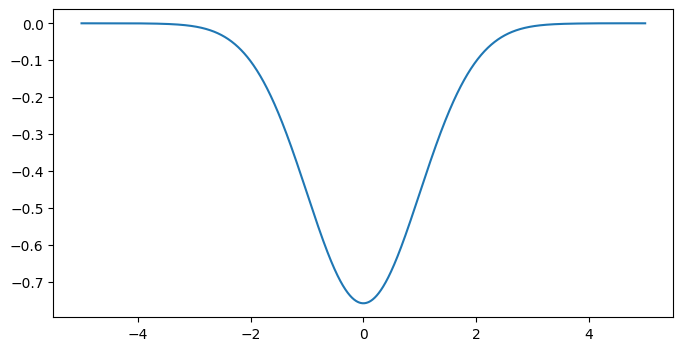

Epoch [7501/10000], Loss: 1.528817847429309e-06, L_orth: 0.0, Energy: 0.5000014305114746, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


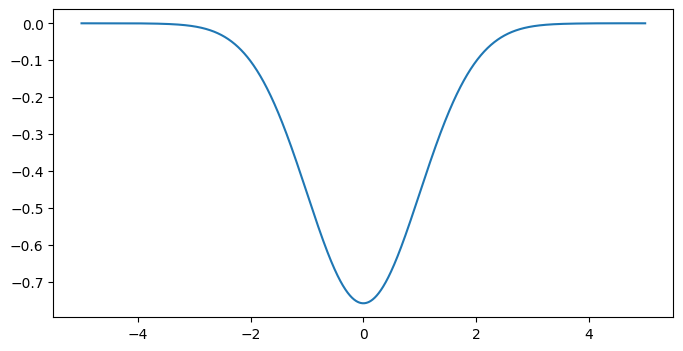

Epoch [8001/10000], Loss: 1.4867316622257931e-06, L_orth: 0.0, Energy: 0.5000010132789612, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


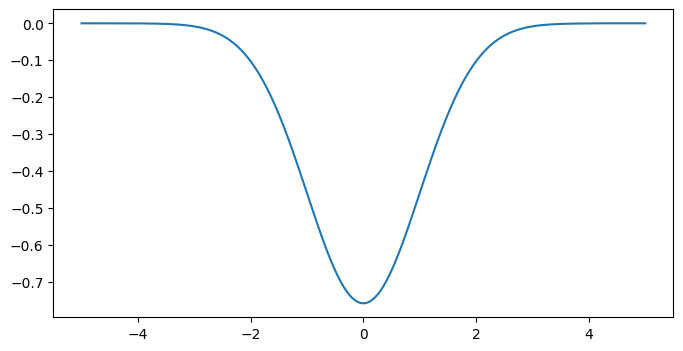

Epoch [8501/10000], Loss: 1.4482395727100084e-06, L_orth: 0.0, Energy: 0.5000007152557373, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


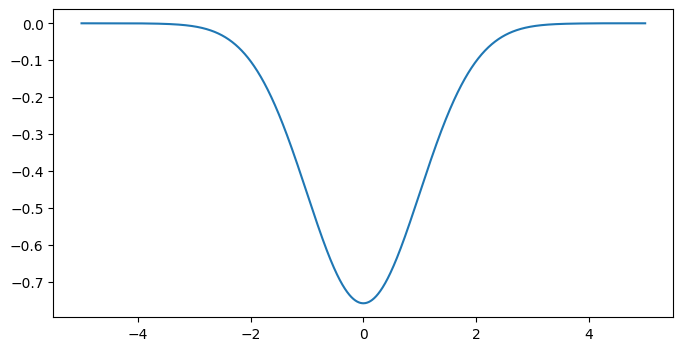

Epoch [9001/10000], Loss: 1.4112904409557814e-06, L_orth: 0.0, Energy: 0.5000005960464478, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


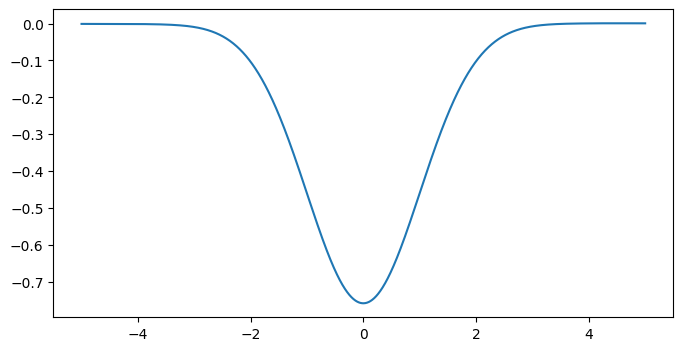

Epoch [9501/10000], Loss: 1.861575037764851e-05, L_orth: 0.0, Energy: 0.5000084638595581, LDE_Loss: 0.0000, Vari_E: 0.5000, Solutions: 0


In [311]:
model = NN(D, Nh, num_layers)

learning_rates = {'lambda_layer': 0.001, 'input_layer': 0.00005, 'output_layer': 0.00005}
for i in range(num_layers):
    layer_name = f"h_layer{i+1}"
    learning_rates[layer_name] = 0.0005
parameters = [{'params': getattr(model, name).parameters(), 'lr': lr} for name, lr in learning_rates.items()]

optimizer = optim.Adam(parameters, lr=0.01)
step_size = 200
gamma = 0.95
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_history, E_history, model_list, l_model = train1D(model, optimizer, scheduler, learning_rates, 10000, num_samples, data_range)

In [ ]:
#MODEL

class NN(nn.Module):
    def __init__(self, D, Nh, num_layers):
        super(NN, self).__init__()
        self.lambda_layer = nn.Linear(1, 1)
        self.input_layer = nn.Linear(1 + D, Nh)
        self.num_layers = num_layers
        for i in range(num_layers):
            setattr(self, f"h_layer{i+1}", nn.Linear(Nh + 1, Nh))
        self.layers = nn.ModuleList([nn.Linear(D + 1, Nh)])
        self.output_layer = nn.Linear(Nh + 1, 1)

    def forward(self, x):
        I = torch.ones((x.shape[0], 1), requires_grad=True)
        E = self.lambda_layer(I)

        input = torch.cat([x, E], dim = 1)
        h = torch.sin(self.input_layer(input))
        for i in range(self.num_layers):
            input_h = torch.cat([h, E], dim = 1)
            layer = getattr(self, f"h_layer{i+1}")
            h = torch.sin(layer(input_h))
        input_h = torch.cat([h, E], dim = 1)

        pred = self.output_layer(input_h)
        return pred, E

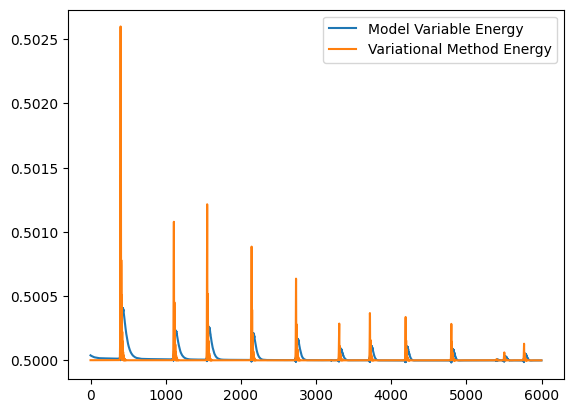

In [312]:
plt.figure()
plt.plot(np.array(E_history)[4000:, 0])
plt.plot(np.array(E_history)[4000:, 1])
plt.legend(("Model Variable Energy", "Variational Method Energy"))
#plt.title("Energy Evolution (1D)")
#plt.xlabel("Epoch")
#plt.ylabel("Energy")
plt.show()

In [ ]:
def train1D(model, optimizer, scheduler, learning_rates, epochs, num_samples, data_range, model_list = []):
    loss_history = []
    E_history = []
    solutions = 0
    convergence = 10000
    
    data = torch.linspace(data_range[0], data_range[1], num_samples).view(-1,1)
    data.requires_grad = True

    edge_indices = torch.any((data == data_range[0]) | (data == data_range[1]), dim=1).nonzero(as_tuple=False).squeeze()

    for epoch in range(epochs):
        if epoch != 0 and epoch % convergence == 0:
            model_list.append(copy.deepcopy(model))
            solutions += 1
            for param_group, (_, lr) in zip(optimizer.param_groups, learning_rates.items()):
                param_group['lr'] = lr

        pred, E = model(data)
        loss, L_DE, L_orth, L_norm, L_BC, var_E= schrodinger_loss(data, pred, E, data_range, solutions, model_list, edge_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(L_DE)
        E_history.append((E.mean().item(), var_E.item()))
        
        if epoch % 500 == 0:
            x = torch.linspace(data_range[0], data_range[1], 2000)
            plt.figure(figsize=(8, 4))
            plt.plot(x, model(x.view(-1,1))[0].detach().numpy())
            plt.show()
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss}, L_orth: {L_orth}, Energy: {E[0].item()}, LDE_Loss: {L_DE.item():.4f}, Vari_E: {var_E.item():.4f}, Solutions: {solutions}')
    return loss_history, E_history, model_list, model

In [ ]:
def train2D(model, optimizer, scheduler, learning_rates, epochs, num_samples, data_range, model_list = []):
    loss_history = []
    E_history = []
    solutions = len(model_list)
    threshold = 2e-5

    data1 = torch.linspace(data_range[0], data_range[1], num_samples)
    data2 = torch.linspace(data_range[0], data_range[1], num_samples)
    X, Y = torch.meshgrid(data1, data2)

    data1 = X.reshape(-1, 1)
    data2 = Y.reshape(-1, 1)
    data_concat = torch.hstack((data1, data2))
    data_concat.requires_grad = True

    edge_indices = torch.any((data_concat == data_range[0]) | (data_concat == data_range[1]), dim=1).nonzero(as_tuple=False).squeeze()
    
    for epoch in range(epochs):
        pred, E  = model(data_concat)     
        loss, L_DE, L_orth, L_norm, L_BC, var_E = schrodinger_loss(data_concat, pred, E, data_range, solutions, model_list, edge_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())
        
        E_history.append((E.mean().item(), var_E.item()))

        if loss < threshold:
            model_list.append(copy.deepcopy(model))
            solutions += 1
            for param_group, (_, lr) in zip(optimizer.param_groups, learning_rates.items()):
                param_group['lr'] = lr
        if solutions == 4:
            break
        
        if epoch % 100 == 0:
            psi_2d = model(data_concat)[0].detach().numpy().reshape(num_samples, num_samples)
            plt.figure(figsize=(8, 6))
            plt.contourf(X, Y, psi_2d, cmap='viridis')
            plt.colorbar(label='Probability amplitude')
            plt.show()
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss}, LDE_Loss: {L_DE.item():.4f}, Orth_Loss: {L_orth.item():.4f}, Eigenvalue: {E[0].item():.4f}, Vari_E: {var_E.item():.4f}, Solutions: {solutions}')
    return loss_history, E_history, model_list, model

In [ ]:
def train3D(model, optimizer, scheduler, learning_rates, epochs, num_samples, data_range, model_params = None):
    loss_history = []
    E_history = []
    solutions = len(model_list)
    convergence = 10000

    data1 = torch.linspace(data_range[0], data_range[1], num_samples)
    data2 = torch.linspace(data_range[0], data_range[1], num_samples)
    data3 = torch.linspace(data_range[0], data_range[1], num_samples)
    X, Y, Z = torch.meshgrid(data1, data2, data3)
    data1 = X.reshape(-1, 1)
    data2 = Y.reshape(-1, 1)
    data3 = Z.reshape(-1, 1)
    data_concat = torch.hstack((data1, data2, data3))
    data_concat.requires_grad = True

    edge_indices = torch.any((data_concat == data_range[0]) | (data_concat == data_range[1]), dim=1).nonzero(as_tuple=False).squeeze()

    for epoch in range(epochs):
        if epoch != 0 and epoch % convergence == 0:
            model_list.append(copy.deepcopy(model))
            solutions += 1
            for param_group, (_, lr) in zip(optimizer.param_groups, learning_rates.items()):
                param_group['lr'] = lr

        pred, E = model(data_concat)
        loss, L_DE, L_orth, L_reg, L_BC, var_E = schrodinger_loss(data_concat, pred, E, data_range, solutions, model_list, edge_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())
        E_history.append((E.mean().item(), var_E.item()))
   
        if epoch % 50 == 0:
            psi_3d = model(data_concat)[0].detach().numpy().reshape(num_samples, num_samples, num_samples)
            probability_density_flat = psi_3d.flatten()

            opacity = np.where(np.abs(probability_density_flat) < 0.2, 0.05, 0.8)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            scatter = ax.scatter(data1, data2, data3, c=probability_density_flat, cmap='viridis', alpha = opacity)
            cbar = fig.colorbar(scatter)
            cbar.set_label('Probability Density')
            plt.show()

            # Projection onto 2D contour plot
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(111)
            contour = ax2.contourf(X[:, :, 0], Y[:, :, 0], psi_3d.sum(axis=2), cmap='viridis')
            cbar2 = fig2.colorbar(contour)
            cbar2.set_label('Probability Density')

            plt.show()
            
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss}, LDE_Loss: {L_DE.item():.4f}, Orth_Loss: {L_orth.item():.4f}, Norm_Loss: {L_reg.item():.4f}, BC_Loss: {L_BC.item():.4f}, Eigenvalue: {E[0].item():.4f}, Vari_E: {var_E.item():.4f}, Solutions: {solutions}')
    return loss_history, E_history, model_list, model

# Below lies code for testing

# 2D

In [ ]:

num = 5000
min_val = -5
max_val = 5
x = (max_val - min_val) * torch.rand(num) + min_val
y = (max_val - min_val) * torch.rand(num) + min_val

concatenated_data = torch.stack((x, y), dim=1)
z = model_list[1](concatenated_data)[0].flatten().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(x, y, z, cmap='coolwarm')

num_ticks = 3
ax.tick_params(axis='x', labelsize=20) 
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)
x_ticks = [min_val, 0, max_val]
y_ticks = [min_val, 0, max_val]
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_zticks([-0.7, 0, 0.7])
print(np.max(z))
print(np.min(z))
plt.show()


In [ ]:
num = 50
min_val = -5
max_val = 5

data1 = torch.linspace(min_val, max_val, num)
data2 = torch.linspace(min_val, max_val, num)
X, Y = torch.meshgrid(data1, data2)

data1 = X.reshape(-1, 1)
data2 = Y.reshape(-1, 1)
data_concat = torch.hstack((data1, data2))
data_concat.requires_grad = True
pred, E = model_list[2](data_concat)

kinematics, grads = kinematics_f(data_concat, pred)
H_psi = kinematics + Nilsson_model(data_concat) * pred

print(E.mean(), torch.sum(pred * H_psi) / torch.sum(pred * pred))

psi_2d = pred.detach().numpy().reshape(num, num)
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, psi_2d, cmap='coolwarm')
colorbar = plt.colorbar(ticks=[-0.7, 0, 0.7])
colorbar.ax.tick_params(labelsize=30)  # Set font size for color bar labels
plt.yticks([-5, 0, 5], fontsize=30)
plt.xticks([-5, 0, 5], fontsize=30)
plt.show()

## 3D Testing

In [ ]:
num = 25
min_val = -5
max_val = 5
data1 = torch.linspace(min_val, max_val, num)
data2 = torch.linspace(min_val, max_val, num)
data3 = torch.linspace(min_val, max_val, num)
X, Y, Z = torch.meshgrid(data1, data2, data3)
data1 = X.reshape(-1, 1)
data2 = Y.reshape(-1, 1)
data3 = Z.reshape(-1, 1)
data_concat = torch.hstack((data1, data2, data3))
data_concat.requires_grad = True

pred, E = l_model(data_concat)

kinematics, grads = kinematics_f(data_concat, pred)
H_psi = kinematics + HO_potential(data_concat) * pred

print(E.mean(), torch.sum(pred * H_psi) / torch.sum(pred * pred))

psi_3d = pred.detach().numpy().reshape(num, num, num)
probability_density_flat = psi_3d.flatten()
print(np.max(probability_density_flat))
print(np.min(probability_density_flat))

opacity = np.where(np.abs(probability_density_flat) < 0.05, 0.01, 0.8)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
num_ticks = 3
ax.tick_params(axis='x', labelsize=20) 
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)
ticks = [min_val, 0, max_val]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)

scatter = ax.scatter(data1, data2, data3, c=probability_density_flat, cmap='viridis', alpha = opacity)
cbar = fig.colorbar(scatter, ticks=[0, 0.07, 0.14])
cbar.ax.tick_params(labelsize=15)
plt.show()

# Projection onto 2D contour plot
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
contour = ax2.contourf(X[:, :, 0], Y[:, :, 0], psi_3d.sum(axis=2), cmap='viridis')
plt.yticks([-5, 0, 5], fontsize=23)
plt.xticks([-5, 0, 5], fontsize=23)

plt.show()

## Energy

In [ ]:
plt.figure()
plt.plot(np.array(E_history)[4000:, 0])
plt.plot(np.array(E_history)[4000:, 1])
plt.legend(("Model Variable Energy", "Variational Method Energy"))
#plt.title("Energy Evolution (1D)")
#plt.xlabel("Epoch")
#plt.ylabel("Energy")
plt.show()

## Loss

In [ ]:
plt.figure()
plt.plot(loss_history[:])
plt.title("Total Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.show()

# Performance

### Data convergence

In [ ]:
num_experiments = 3
num_samples_experiments = [20, 40, 60]
model = NN(D, Nh)
model_params = model.state_dict()
for i in num_samples_experiments:
    

    learning_rates = {'lambda_layer': 0.1, 'layer1': 0.0005, 'layer2': 0.0005, 'layer3': 0.0005, 'layer4': 0.0005}
    parameters = [{'params': getattr(model, name).parameters(), 'lr': lr} for name, lr in learning_rates.items()]

    optimizer = optim.Adam(parameters, lr=0.01)
    step_size = 1000 
    gamma = 0.95
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history, E_history, model_list, l_model = train2D(model, optimizer, scheduler, learning_rates, 200000, i, data_range, model_params)
    

In [ ]:
li = [-4.4278, -4.4164]
av = np.mean(li)
n_samp = len(li)
conf_level = 0.95
s = np.std(li)

right = conf_level * s /np.sqrt(n_samp)
print(av, right)
print(av - right, av + right)

In [ ]:
li = [3.5033, 3.5034]
target = 3.5
sum = 0
for i in li:
    sum += np.abs((i - target)/target)
av_rel = sum / len(li)
print(av_rel)

In [ ]:
-5.8421, -5.8475
-5.1955, -5.2290
-5.2096, -5.2286
-5.2133, -5.2261

In [ ]:
[93067, 131397, 153005, 171040]